In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pyeit.eit.utils import eit_scan_lines
import pandas as pd
from pyeit.mesh.meshpy.build import create
import pyeit.eit.jac as jac

In [64]:
def calculate_features(mask_gray):
    # Create a color version of the mask to draw colored annotations on
    visualization_img = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2BGR)

    # 2. Find the TANK contour by looking for the black area in the mask.
    _, tank_binary_mask = cv2.threshold(mask_gray, 128, 255, cv2.THRESH_BINARY_INV)
    tank_contours, _ = cv2.findContours(tank_binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not tank_contours:
        print("Error: Could not find the black tank contour.")
        return None
    tank_contour = max(tank_contours, key=cv2.contourArea)
    cv2.drawContours(visualization_img, [tank_contour], -1, (0, 255, 0), 2) # Draw green tank wall

    # 3. Find the PHANTOM contour using a more robust masking technique
    h, w = mask_gray.shape
    filled_tank_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(filled_tank_mask, [tank_contour], -1, 255, -1)
    _, all_white_mask = cv2.threshold(mask_gray, 128, 255, cv2.THRESH_BINARY)
    isolated_phantom_mask = cv2.bitwise_and(all_white_mask, filled_tank_mask)
    phantom_contours, _ = cv2.findContours(isolated_phantom_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not phantom_contours:
        print("Error: Could not find a white phantom contour inside the tank area.")
        return None
        
    phantom_contour = max(phantom_contours, key=cv2.contourArea)
    cv2.drawContours(visualization_img, [phantom_contour], -1, (0, 0, 255), 2) # Draw red phantom outline

    # 4. Calculate features: Area and Distance
    phantom_area = cv2.contourArea(phantom_contour)
    (_, _), tank_radius_pixels = cv2.minEnclosingCircle(tank_contour)
    min_dist = float('inf')
    closest_points = (None, None)

    for pt in phantom_contour:
        point_tuple = (int(pt[0,0]), int(pt[0,1]))
        dist = abs(cv2.pointPolygonTest(tank_contour, point_tuple, True))
        if dist < min_dist:
            min_dist = dist
            closest_points = (point_tuple, None)

    # 5. Draw annotations for visualization
    if closest_points[0]:
        phantom_pt = closest_points[0]
        min_viz_dist = float('inf')
        tank_pt = None
        for wall_pt in tank_contour:
            wall_point_tuple = (int(wall_pt[0,0]), int(wall_pt[0,1]))
            dist_viz = np.linalg.norm(np.array(phantom_pt) - np.array(wall_point_tuple))
            if dist_viz < min_viz_dist:
                min_viz_dist = dist_viz
                tank_pt = wall_point_tuple
        
        if tank_pt:
            closest_points = (phantom_pt, tank_pt)
            cv2.line(visualization_img, closest_points[0], closest_points[1], (255, 255, 0), 2)
            cv2.circle(visualization_img, closest_points[0], 4, (255, 0, 0), -1)
            cv2.circle(visualization_img, closest_points[1], 4, (255, 0, 0), -1)

    # Prepare results
    results = { 
        'area': phantom_area, 
        'distance_to_wall': min_dist, 
        'tank_radius_pixels': tank_radius_pixels,
        'visualization_img': visualization_img 
    }
    return results

In [56]:
def calculate_distance_from_white_bg_mask(mask_path):
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_gray is None:
        print(f"Error: Could not load manual mask from {mask_path}")
        return None
    results = calculate_features(mask_gray)

    return results

In [ ]:
def create_custom_boundary_func(csv_path="circle.csv"):
    """
    This function returns another function that will be used as the 'curve'
    argument in the older pyeit.mesh.create.
    """
    try:
        data = pd.read_csv(csv_path)
        # The points are scaled by 100 as in your original code
        scaled_points = (data[['x', 'y']].values / 100).tolist()
        
        def curve_func(n_el=16):
            """
            This inner function is what's actually passed to the mesher.
            It returns the boundary points and the number of points.
            """
            return scaled_points, [len(scaled_points)]
            
        return curve_func

    except FileNotFoundError:
        print(f"Error: The file '{csv_path}' was not found.")
        return None


In [45]:
def convert_recon_to_image(ds, mesh, mesh_radius, image_size=(512, 512)):
    """ 
    Renders the 1D permittivity vector 'ds' into a 2D image.
    *** UPDATED to enforce a clean circular boundary with correct background value. ***
    """
    img = np.zeros(image_size, dtype=np.float32)
    nodes = mesh['node']
    elements = mesh['element']
    
    # Map node coordinates from mesh space to pixel space
    pts = np.array(nodes)
    pts = (pts + mesh_radius) * (image_size[0] / (2 * mesh_radius))
    pts = pts.astype(int)

    # Draw each triangle with its corresponding permittivity value
    for i, element in enumerate(elements):
        p1 = tuple(pts[element[0]])
        p2 = tuple(pts[element[1]])
        p3 = tuple(pts[element[2]])
        triangle = np.array([p1, p2, p3])
        cv2.fillPoly(img, [triangle], color=float(ds[i]))

    # --- ADDED: Create and apply a circular mask ---
    h, w = image_size
    circle_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(circle_mask, (w//2, h//2), w//2, 1, -1) # Use 1 for mask value
    
    # Find the true minimum value within the valid tank area
    # This ensures the background is always the darkest part
    min_val_in_tank = np.min(img[circle_mask == 1])
    
    # Create the final masked image
    # Initialize with the minimum value
    img_masked = np.full(image_size, min_val_in_tank, dtype=np.float32)
    # Copy over the valid tank area using the mask
    img_masked[circle_mask == 1] = img[circle_mask == 1]

    return img_masked

In [67]:
def calculate_features_from_image(binary_mask):
    """
    Calculates area and distance using OpenCV on a binary mask.
    This is similar to the ground truth processing script.
    """
    h, w = binary_mask.shape
    # Define the tank wall as a circle inscribed in the image
    tank_center = (w // 2, h // 2)
    tank_radius = w // 2

    # Find the contour of the phantom
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return {'area': 0, 'distance': tank_radius} # Return 0 area and max distance if no object
    
    phantom_contour = max(contours, key=cv2.contourArea)

    # Calculate Area
    area = cv2.contourArea(phantom_contour)
    
    # Calculate contour-to-contour distance
    min_dist = float('inf')
    for pt in phantom_contour:
        dist_to_center = np.linalg.norm(np.array(pt.ravel()) - np.array(tank_center))
        dist_to_wall = tank_radius - dist_to_center
        if dist_to_wall < min_dist:
            min_dist = dist_to_wall
            
    return {'area': area, 'distance': min_dist}

In [78]:
def get_reconstruction_features(ds, mesh, mesh_radius, pixels_per_unit):
    """
    Calculates area and distance by converting the reconstruction to an image.
    Uses Otsu's method for automatic thresholding.
    Now also returns the binary mask and the rendered image for visualization.
    """
    # 1. Render the reconstruction into a 2D float image (already grayscale)
    recon_image = convert_recon_to_image(ds, mesh, mesh_radius)

    # 2. Prepare image for thresholding
    min_val, max_val = np.min(recon_image), np.max(recon_image)
    if (max_val - min_val) > 0:
        recon_image_normalized = 255 * (recon_image - min_val) / (max_val - min_val)
        recon_image_inverted = 255 - recon_image_normalized
    else:
        recon_image_inverted = np.zeros_like(recon_image)

    grayscale_image_8bit = recon_image_inverted.astype(np.uint8)

    # 3. Apply Otsu's thresholding to get a binary mask
    _, binary_mask = cv2.threshold(grayscale_image_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 4. Calculate features from the binary mask image
    recon_features_pixels = calculate_features_from_image(binary_mask)
    
    # 5. Convert pixel features back to mesh units for comparison
    recon_area_mesh_units = recon_features_pixels['area'] / (pixels_per_unit ** 2)
    recon_dist_mesh_units = recon_features_pixels['distance'] / pixels_per_unit

    # UPDATED: Return all artifacts for visualization
    return {
        'area': recon_area_mesh_units, 
        'distance': recon_dist_mesh_units, 
        'recon_image': recon_image,
        'mask': binary_mask
    }

# Run the Image Reconstruction

In [71]:
MANUAL_MASK_PATH = 'masked_gt/1cm_el05.png' 
HOMOGEN_PATH = 'Dataset/BG_Homogen/02072024_Adj_0=100000Hz.csv'
INCLUSION_PATH = 'Dataset/INC_Adjacent_main/02072024_5_Obj_1cm_Adj_0=100000Hz.csv'

Using manual mask: masked_gt/1cm_el05.png

--- Extracted Ground Truth Feature ---
Phantom Area: 968.00 pixels^2
Shortest distance between contours: 48.37 pixels
Detected Tank Radius: 176.08 pixels


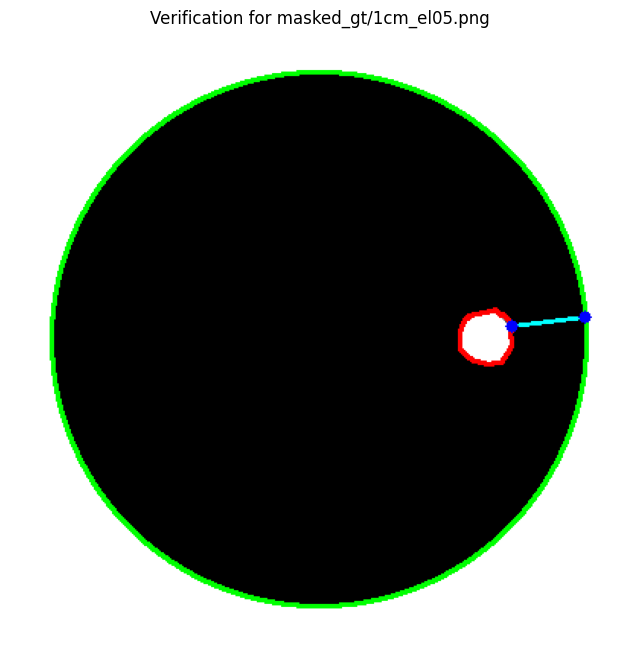

In [72]:
print(f"Using manual mask: {MANUAL_MASK_PATH}")
features = calculate_distance_from_white_bg_mask(MANUAL_MASK_PATH)

if features is not None:
    # Print the extracted features
    print("\n--- Extracted Ground Truth Feature ---")
    print(f"Phantom Area: {features['area']:.2f} pixels^2")
    print(f"Shortest distance between contours: {features['distance_to_wall']:.2f} pixels")
    # *** ADDED: Print the tank radius ***
    print(f"Detected Tank Radius: {features['tank_radius_pixels']:.2f} pixels")
    
    # Display the visualization image to verify the process
    verification_image_rgb = cv2.cvtColor(features['visualization_img'], cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(verification_image_rgb)
    plt.title(f'Verification for {MANUAL_MASK_PATH}')
    plt.axis('off')
    plt.show()
else:
    print("\nFeature extraction failed. Please check the image path and format.")

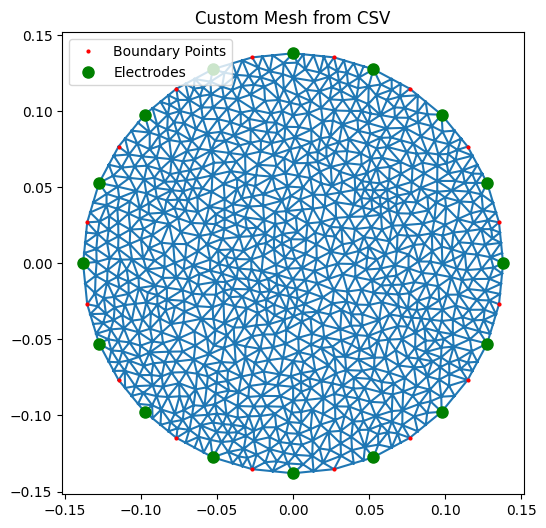

In [73]:
# --- Main Execution ---
N_el = 16
MAX_TRIANGLE_AREA = 0.00005 

custom_curve_function = create_custom_boundary_func()

if custom_curve_function is not None:
    mesh_obj, el_pos_from_create = create(num_el=N_el, 
                                           max_area=MAX_TRIANGLE_AREA, 
                                           curve=custom_curve_function, 
                                           refine=True)

    # --- Step 3: Manually define electrode positions for robustness ---
    # 1. Load the original boundary points again to ensure we have them.
    boundary_data = pd.read_csv("circle.csv")
    boundary_pts = (boundary_data[['x', 'y']].values / 100)
    
    # 2. Select N_el equally spaced points from our boundary list.
    # Since we have 32 points and want 16 electrodes, we take every 2nd point.
    step = len(boundary_pts) // N_el
    electrode_pts = boundary_pts[::step]

    # 3. Find the index of the closest node in the mesh for each of our selected points.
    el_pos = []
    for el_pt in electrode_pts:
        # Find the node in mesh_obj['node'] that is closest to our electrode point
        dist = np.linalg.norm(mesh_obj['node'] - el_pt, axis=1)
        closest_node_index = np.argmin(dist)
        el_pos.append(closest_node_index)
    
    el_pos = np.array(el_pos, dtype=int)

    # --- Step 4: Assemble the final mesh dictionary with our correct el_pos ---
    final_mesh = {
        'node': mesh_obj['node'],
        'element': mesh_obj['element'],
        'el_pos': el_pos, # Use our manually calculated positions
        'perm': np.ones(len(mesh_obj['element']))
    }
    
    # --- Step 5: Visualize the result for verification ---
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.triplot(final_mesh['node'][:, 0], final_mesh['node'][:, 1], final_mesh['element'])
    # Plot all original boundary points to see the shape
    ax.plot(boundary_pts[:, 0], boundary_pts[:, 1], 'r.', markersize=4, label='Boundary Points')
    # Plot our correctly placed electrodes
    ax.plot(final_mesh['node'][el_pos, 0], final_mesh['node'][el_pos, 1], 'go', markersize=8, label='Electrodes')
    ax.set_title('Custom Mesh from CSV')
    ax.set_aspect('equal')
    ax.legend()
    plt.show()
else:
    print("Could not create mesh because the CSV file was not found.")

In [74]:
try:
    vh_df = pd.read_csv(HOMOGEN_PATH)
    vi_df = pd.read_csv(INCLUSION_PATH)
    vh = vh_df['Z [Ohm]'].values
    vi = vi_df['Z [Ohm]'].values
    print("Voltage data loaded successfully.")
except FileNotFoundError:
    print("Error: Voltage files not found.")
    # Use dummy data if files are not found, so the script can still run
    vh = np.ones(N_el * (N_el - 1) // 2) 
    vi = vh * 1.05

Voltage data loaded successfully.


In [75]:
ground_truth_features = {
    'area_pixels': features['area'], # Example value
    'distance_pixels': features['distance_to_wall'], # Example value
    'tank_radius_pixels': features['tank_radius_pixels'] # Example value
}
print("Ground truth features loaded.")

Ground truth features loaded.


In [76]:
# Calculate the effective radius of the custom mesh
node_distances_from_center = np.linalg.norm(final_mesh['node'], axis=1)
mesh_radius_units = np.max(node_distances_from_center)

# Calculate the calibration factor
pixels_per_unit = ground_truth_features['tank_radius_pixels'] / mesh_radius_units

# Convert ground truth features to mesh units
gt_area_mesh_units = ground_truth_features['area_pixels'] / (pixels_per_unit ** 2)
gt_distance_mesh_units = ground_truth_features['distance_pixels'] / pixels_per_unit

print("\n--- Calibration Complete ---")
print(f"Mesh Radius: {mesh_radius_units:.4f} units")
print(f"Calibration Factor: {pixels_per_unit:.2f} pixels per mesh unit")
print(f"Calibrated GT Area: {gt_area_mesh_units:.6f} mesh units^2")
print(f"Calibrated GT Distance: {gt_distance_mesh_units:.6f} mesh units")


--- Calibration Complete ---
Mesh Radius: 0.1380 units
Calibration Factor: 1275.66 pixels per mesh unit
Calibrated GT Area: 0.000595 mesh units^2
Calibrated GT Distance: 0.037921 mesh units


In [79]:
# Set up the EIT solver
ex_mat = eit_scan_lines(N_el, 1) # Adjacent stimulation pattern
eit = jac.JAC(final_mesh, el_pos, ex_mat=ex_mat, step=1, perm=1.0)

# Define the grid of p-values to search
p_values = np.linspace(0.05, 1.0, 20)
results = []

print("\n--- Starting Grid Search for pVal ---")
for p in p_values:
    # Set up the solver with the current p-value
    eit.setup(p=p, lamb=0.01, method='kotre') # Using 'kotre' method from reference
    
    # Solve the inverse problem
    ds = eit.solve(vi, vh, normalize=True)
    
    # Extract features and the mask from the reconstruction
    recon_features = get_reconstruction_features(ds, final_mesh, mesh_radius_units, pixels_per_unit)
    recon_image_to_show = recon_features['recon_image']
    binary_mask_from_recon = recon_features['mask']
    
    # Calculate errors
    area_error = abs(gt_area_mesh_units - recon_features['area'])
    dist_error = abs(gt_distance_mesh_units - recon_features['distance'])
    
    results.append({
        'p': p,
        'area_error': area_error,
        'dist_error': dist_error,
        'reconstruction': ds # Store the result for later visualization
    })
    print(f"p={p:.2f} | Area Error: {area_error:.6f} | Distance Error: {dist_error:.6f}")

# Find the best p-value (e.g., based on minimizing total error)
results_df = pd.DataFrame(results)
results_df['total_error'] = results_df['area_error'] + results_df['dist_error']
best_result = results_df.loc[results_df['total_error'].idxmin()]

print("\n--- Grid Search Complete ---")
print(f"Optimal pVal found: {best_result['p']:.2f}")


--- Starting Grid Search for pVal ---
p=0.05 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.10 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.15 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.20 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.25 | Area Error: 0.009088 | Distance Error: 0.119937
p=0.30 | Area Error: 0.017810 | Distance Error: 0.119937
p=0.35 | Area Error: 0.055841 | Distance Error: 0.119937
p=0.40 | Area Error: 0.027276 | Distance Error: 0.023831
p=0.45 | Area Error: 0.020822 | Distance Error: 0.034916
p=0.50 | Area Error: 0.015638 | Distance Error: 0.034916
p=0.55 | Area Error: 0.011545 | Distance Error: 0.046000
p=0.60 | Area Error: 0.007971 | Distance Error: 0.046000
p=0.65 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.70 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.75 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.80 | Area Error: 0.007941 | Distance Error: 0.121045
p=0.85 | Area Error: 0.007941 | Distance Error: 0

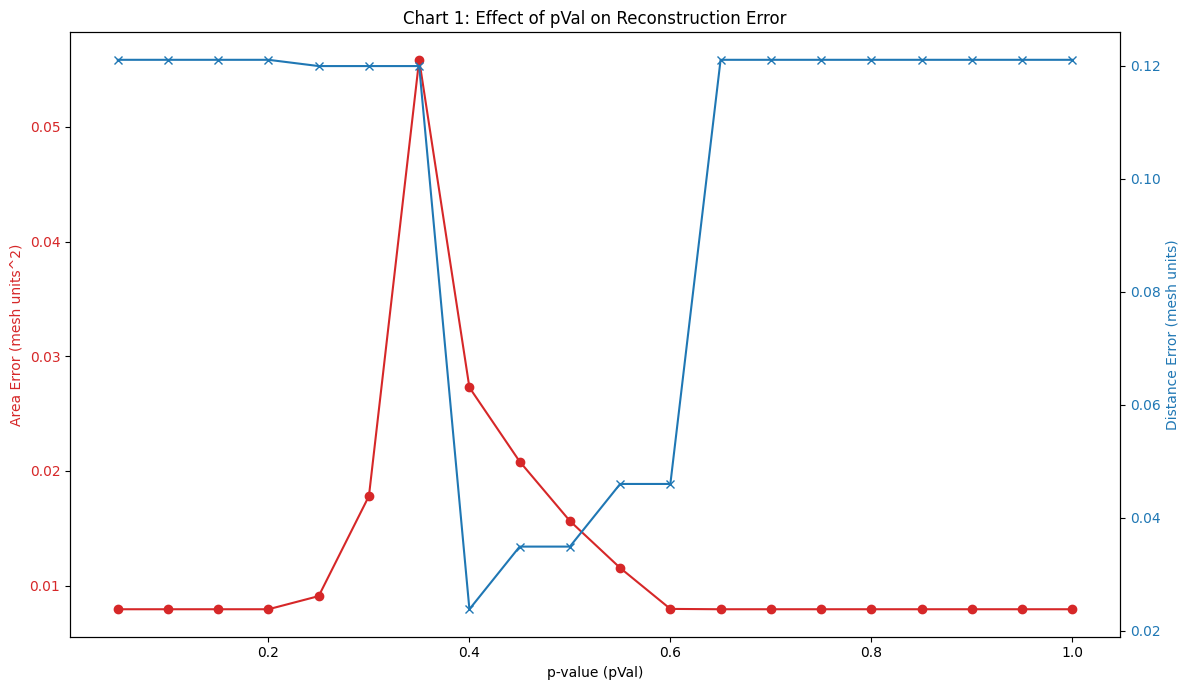

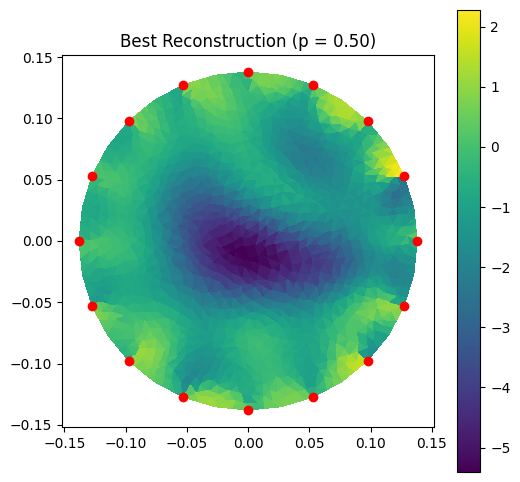

In [80]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Area Error
color = 'tab:red'
ax1.set_xlabel('p-value (pVal)')
ax1.set_ylabel('Area Error (mesh units^2)', color=color)
ax1.plot(results_df['p'], results_df['area_error'], color=color, marker='o', label='Area Error')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Distance Error on a second y-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Distance Error (mesh units)', color=color)
ax2.plot(results_df['p'], results_df['dist_error'], color=color, marker='x', label='Distance Error')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Chart 1: Effect of pVal on Reconstruction Error')
fig.tight_layout()  
plt.show()

# Visualize the best reconstruction
best_ds = best_result['reconstruction']
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.tripcolor(final_mesh['node'][:, 0], final_mesh['node'][:, 1], final_mesh['element'],
                  best_ds, shading='flat', cmap=plt.cm.viridis)
ax.set_title(f"Best Reconstruction (p = {best_result['p']:.2f})")
ax.plot(final_mesh['node'][el_pos, 0], final_mesh['node'][el_pos, 1], 'ro')
ax.set_aspect('equal')
fig.colorbar(im)
plt.show()